<a href="https://colab.research.google.com/github/rocioparra/redes-neuronales/blob/master/02-naive-bayes/RN20202Q_NaiveBayes_Parra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset: Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) es un dataset con imágenes de prendas de vestir (artículos de la compañía Zalando). Son 70000 imágenes en baja resolución (28x28 pixeles), en escala de grises, agrupadas en 10 clases. Se utiliza en la comunidad de Machine Learning para comparación de algoritmos, de la misma forma que el dataset MNIST.

In [1]:
from sklearn.datasets import fetch_openml 
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)

In [2]:
import numpy as np

H = 28
W = 28
X = X.reshape(70000,H,W)

X = X.astype(np.uint8)
y = y.astype(np.int8)

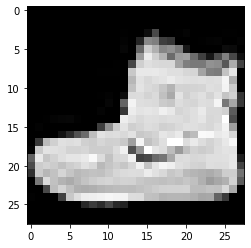

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(X[0], cmap="gray")
plt.show()

El objetivo de esta práctica es utilizar la técnica de Naive Bayes como clasificador de imágenes, preparando una notebook para obtener las respuestas del cuestionario en Campus

### Consignas a resolver

In [7]:
label_dict = {
    i: article for i, article in enumerate(
    ['T-shirt/top', 
     'Trouser',
     'Pullover',
     'Dress',
     'Coat',
     'Sandal',
     'Shirt',
     'Sneaker',
     'Bag',
     'Ankle boot']
    )
}

- Redimensionar los datos de entrada con la dimensión de las imágenes

In [6]:
imgs = X.reshape(-1,28,28)

- Graficar las primeras 150 imágenes como una grilla. 


In [4]:
def img_grid(imgs, n_rows):
    # reshape to a grid
    n_columns = len(imgs)//n_rows
    imgs = np.array(imgs).reshape((n_rows, n_columns, 28, 28))
    imgs = imgs.swapaxes(1, 2).reshape((n_rows*28, n_columns*28))
    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(20,15))
    ax.imshow(imgs, cmap="gray")
    ax.axis('scaled')
    plt.show()

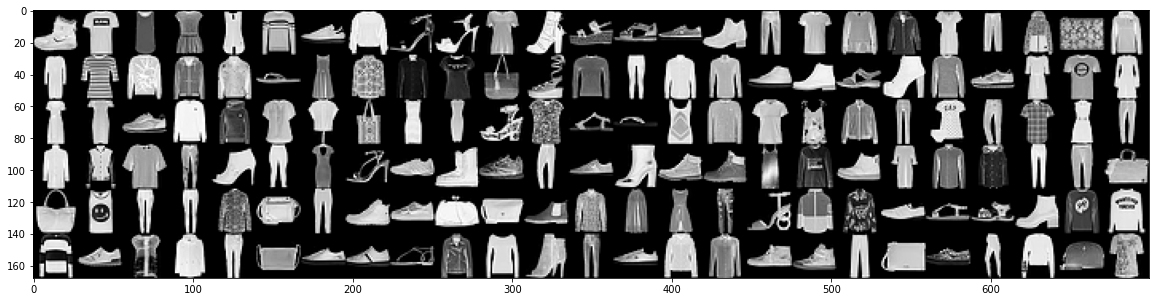

In [8]:
img_grid(imgs[:150], n_rows=6)

- Graficar las primeras 100 imágenes de cada clase

Ankle boot


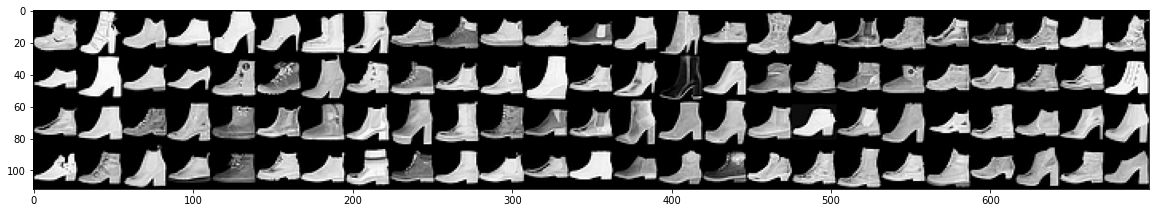

T-shirt/top


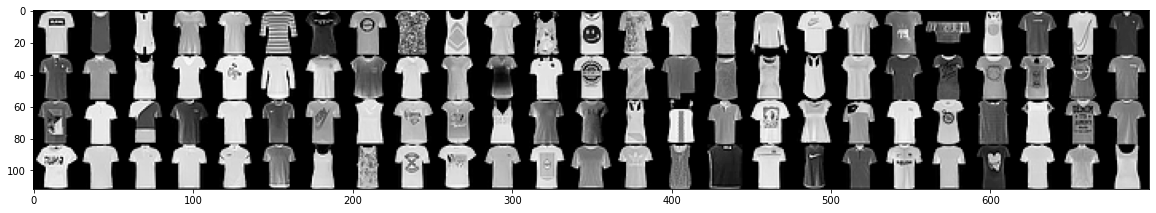

Dress


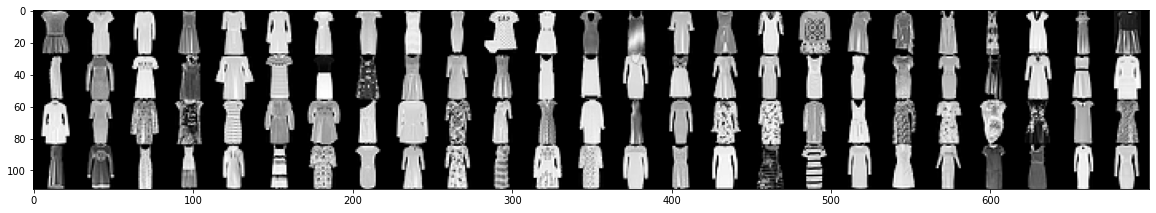

Pullover


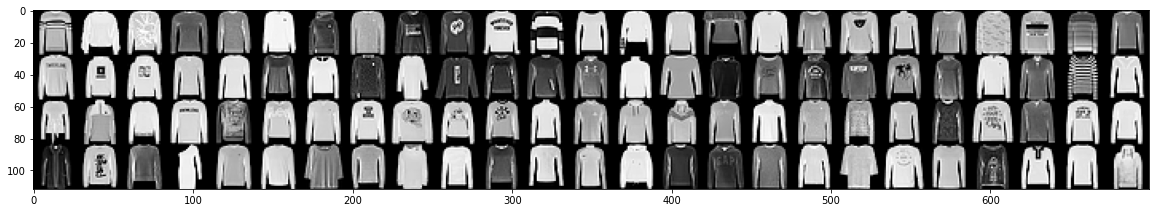

Sneaker


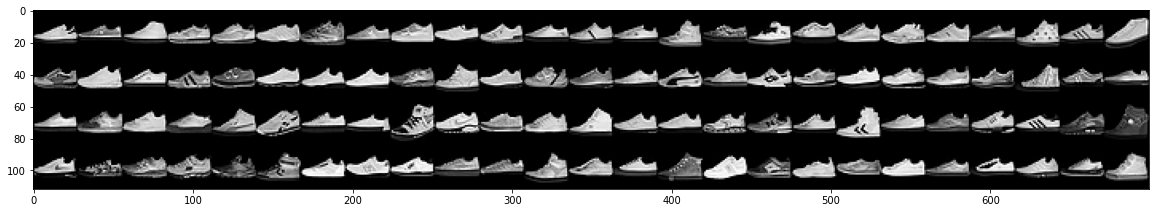

Sandal


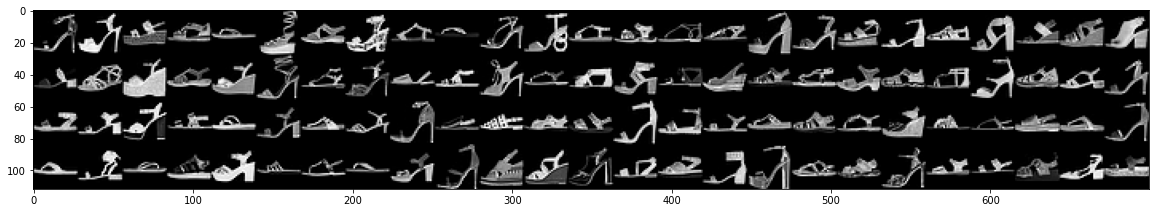

Trouser


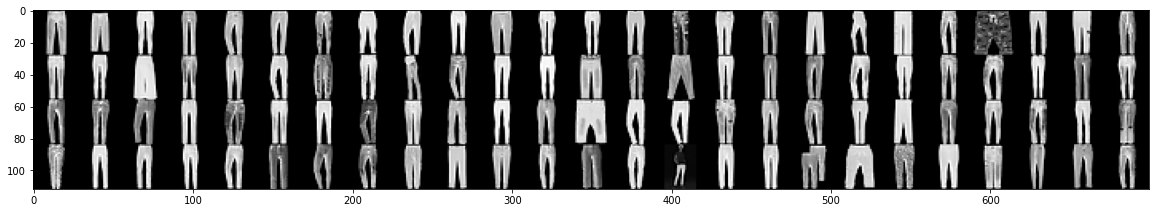

Shirt


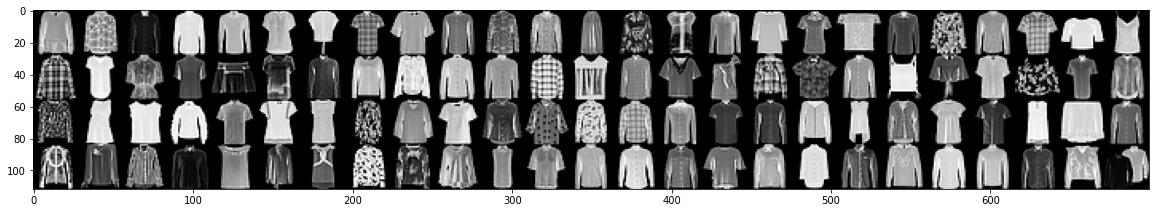

Coat


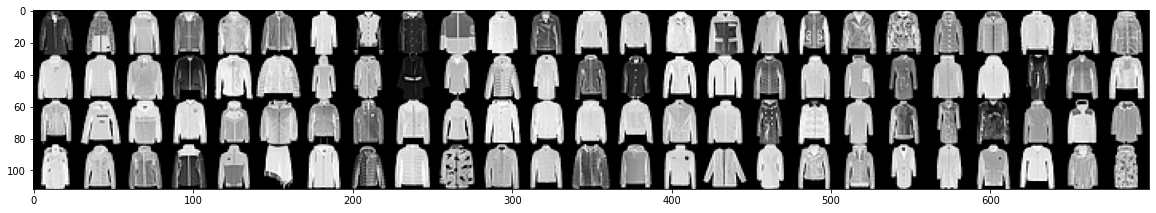

Bag


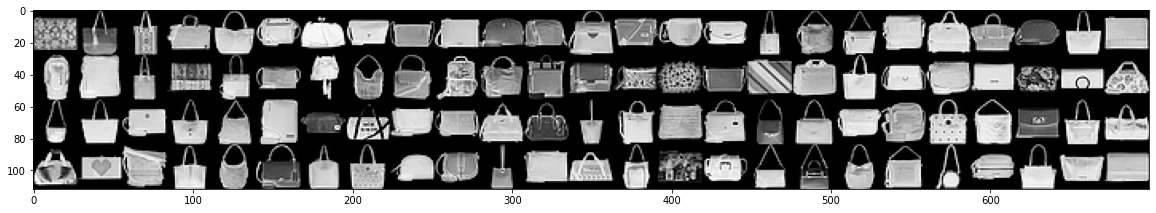

In [19]:
from collections import defaultdict

# classify by type of clothing
clothes = defaultdict(list)
for i, article in enumerate(y):
    clothes[label_dict[article]].append(imgs[i])

# show grid with 100 first imgs of each article
for article in clothes:
    clothes[article] = np.array(clothes[article])
    print(article)
    img_grid(clothes[article][:100], n_rows=4)

**Split train-validation**

- Dividir los datos en train, validation y test, en un ratio 5:1:1, usando **random_state=42**. De forma estratificada por clases

Función útil: *sklearn.model_selection.train_test_split*



In [5]:
from sklearn.model_selection import train_test_split

ratios = (5, 1, 1)  # train / validation / test

# get test set
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, random_state=42, stratify=y,
    test_size=ratios[2]/sum(ratios)
)

# split remainder between train and validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, random_state=42, stratify=y_train_valid,
    test_size=ratios[1]/sum(ratios[:2])
)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_valid)}')
print(f'Test size: {len(X_test)}')                                                        

Train size: 50000
Validation size: 10000
Test size: 10000


## Naive Bayes Multinomial

Vamos a construir un clasificador de imágenes para el dataset Fashion MNIST usando el método de Naive Bayes Multinomial

- Construir un histograma de 255 bins para la distribución del nivel de gris del pixel [15,15] en imágenes de clase “Dress”.

Función útil: *plt.hist()*

In [21]:
class Article:
    """
    Article object: name + all associated images & a priori prob
    article.
    article.imgs -> all images, access order [img][row][col]
    article.from_pxls -> all images, access order [row][col][img]
    article.priori -> a priori probability
    """
    def __init__(self, name, pics, priori):
        self.name = str(name)       
        self.priori = priori        

        self.imgs = np.array(pics)  
        self.from_pxls = self.imgs.swapaxes(0, 1).swapaxes(1, 2) 
    
    def __len__(self):
        return len(self.imgs)
    
    def __str__(self):
        return self.name


def clothes_dict(names, pics):
    """
        create dictionary where
        - key: name of article (dress, bag...)
        - value: Article object
    """
    clothes = defaultdict(list)
    
    # classify images by article
    for i, article in enumerate(names):
        clothes[label_dict[article]].append(pics[i])
    
    # replace image lists for article objects, and calculate a priori probs
    for name in clothes:
        clothes[name] = Article(name=name, pics=clothes[name], 
                                priori=len(clothes[name])/len(pics))
    
    return clothes

In [22]:
# classify clothes in train
clothes_train = clothes_dict(names=y_train, pics=X_train.reshape(-1, 28, 28))

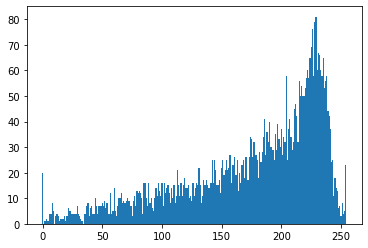

15


In [23]:
hist, bins = np.histogram(clothes_train['Dress'].from_pxls[15][15], bins=255)
plt.bar(x=bins[:-1], height=hist, width=1)
plt.show()
print(hist[147])

- Calcular la probabilidad a priori de la clase "Dress"

In [24]:
dress = clothes_train['Dress']
print(dress.priori)

0.1


- Calcular el likelihood del nivel de gris $x_g=147$ para la clase 'Dress', utilizando 255 niveles de gris

In [25]:
hist255 = np.histogram(dress.from_pxls[15][15], bins=255)[0] / len(dress)
print(hist255[147] * dress.priori)

0.00030000000000000003


- Calcular el likelihood del nivel de gris $x_g=147$ para la clase 'Dress', utilizando 10 niveles de gris

In [26]:
hist10 = np.histogram(dress.from_pxls[15][15], bins=10)[0] / len(dress)
print(hist10[(147*10)//255] * dress.priori)

0.00842


- Crear una matriz de 28x28x10 que tenga los likelihoods de cada posición para cada clase 

In [27]:
likelihoods = {
    name: np.array(
        [[np.histogram(article.from_pxls[i][j], bins=10)[0]/len(article) * article.priori  
          for j in range(28)] 
         for i in range(28)]
        ) 
    for name, article in clothes_train.items() 
}

In [33]:
for l, likelihood in likelihoods.items():
    clothes_train[l].likelihoods = likelihood

- ¿Cuál es la probabilidad a posteriori no normalizada de que un pixel con $x_g=124$ en la posición $[17,17]$ pertenezca a la clase "Bag"? 

In [34]:
likelihoods['Bag'][17][17][(124*10)//255]

0.00662

### Clasificador NBM y búsqueda de hiperparámetros:

Ajustar un modelo NBM a los datos de X_train, y realizar una búsqueda por grilla de hiperparámetros, utilizando los datos de X_valid para calcular el desempeño del modelo con cada combinación de hiperparámetros.

Probar los siguientes valores de hiperparámetros y sus posibles combinaciones:

- Cantidad de niveles de gris: {10, 64, 128, 255}

- Smoothing: Alfa={0.1,0.01,0.001,0.0001}

- Agrupamiento de píxeles: dimensión del grupo={[1,1],[2,2],[2,1],[4,4]}

Método:

*sklearn.naive_bayes.MultinomialNB*



In [6]:
grey_levels = (10, 64, 128, 256)
alphas = (0.1, 0.01, 0.001, 0.0001)
group_sizes = tuple(np.array(size) for size in ([1,1], [2,2], [2,1], [4,4]))

In [7]:
X_train = X_train.reshape(-1, H*W)
X_valid = X_valid.reshape(-1, H*W)
X_test = X_test.reshape(-1, H*W)

In [8]:
def getExpandido(x, w, h):
    """Funcion para agrupar píxeles por grupos.
    Debe tomar un conjunto X de N matrices de HxW, y devuelve un nuevo conjunto
     X_expandido de N*width*height matrices de HxW según lo visto en la presentación
    Pasos:
    1. Si X es unidimensional, reshapearlo a matrices
    2. Muestrear cada matriz para generar width*height matrices de menor dimensión (H/height x W/width)
    3. Concatenar estas matrices
    4. Repetir cada pixel para llevar las matrices a la dimension original HxW

    Funciones útiles: -samplear vectores por paso
                      -np.concatenate()
                      -np.repeat()
    """
    x = x.reshape(-1, H // h, h, W // w, w)  # split each img into h*w groups
    x = x.swapaxes(1, 2).swapaxes(2, 4).swapaxes(3, 4)  # split groups
    x = x.reshape(-1, H // h, W // w)  # split each img into h*w images
    x = x.repeat(h, axis=1).repeat(w, axis=2)  # resize images
    return x.reshape(-1, H * W)

Original:


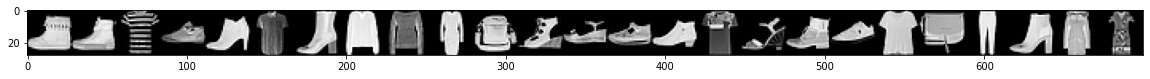

Expandido 2x2:


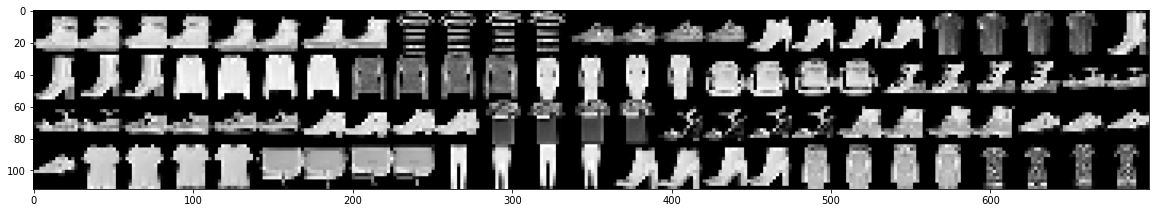

In [10]:
imgs = X_train[:25]
x = getExpandido(imgs, 2, 2)

print("Original:")
img_grid(imgs, n_rows=1)
print("Expandido 2x2:")
img_grid(x, n_rows=4)

In [11]:
def getNewGrayLevels(x, bins):
    """
    Función que transforme los valores de gris de x
    para llevarlos a una nueva escala con len(bins) valores de gris,
    donde cada elemento de bins es un valor de la escala.

    """
    if bins == 256:
        return x
    delta = 255 / (bins - 1)  # new minimum diff between two values
    x = x.astype(float) + delta / 2  # ensure that the result of // be rounded instead of truncated
    return np.round((x // delta) * delta).astype(np.uint8)  # round x to multiples of delta

Original:


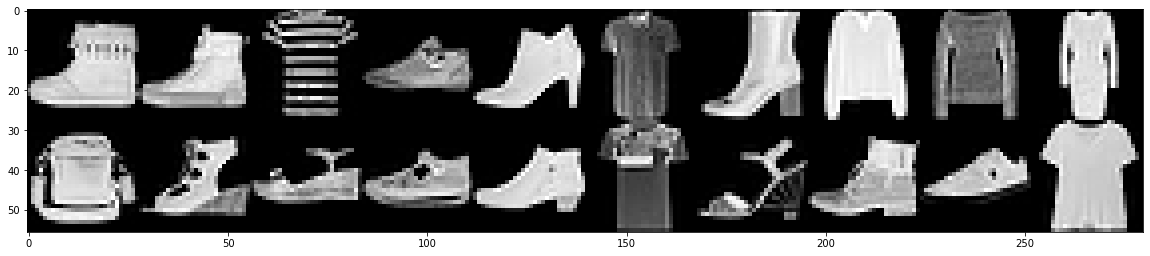

Con 10 niveles de gris:


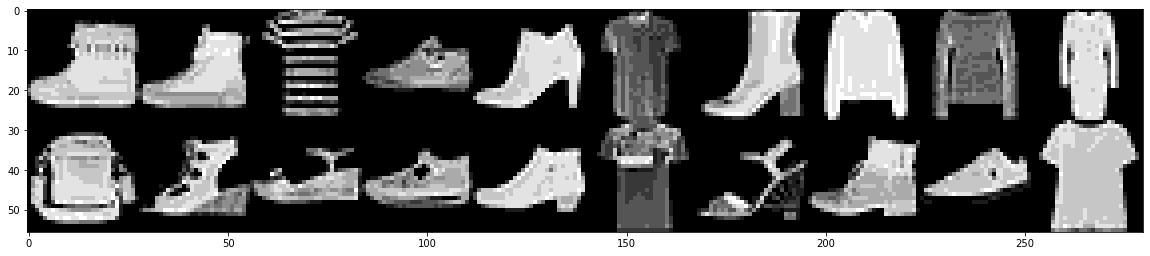

In [12]:
imgs = X_train[:20]
x = getNewGrayLevels(imgs, 10)

print("Original:")
img_grid(imgs, n_rows=2)
print("Con 10 niveles de gris:")
img_grid(x, n_rows=2)


In [15]:
#Guardar las versiones de matrices con distintas escalas de niveles de gris, porque tardan en procesarse

x_train_g = {}
x_valid_g = {}
for grey in grey_levels:
    x_train_g[grey] = getNewGrayLevels(X_train, grey)
    x_valid_g[grey] = getNewGrayLevels(X_valid, grey)


In [19]:
# Recorrer todas las combinaciones de escalas, grupos de pixeles y alfas,registrando el accuracy en 
#validacion

from sklearn.naive_bayes import MultinomialNB

accuracies = []

for grey in grey_levels:
    
    for size in group_sizes:
        x = getExpandido(x_train_g[grey], *size)
        y = y_train.repeat(size[0] * size[1])

        for alpha in alphas:
            # print(f'Computing: S={size}, G={grey}, A={alpha}...')
            print(f'Computing: G={grey}, S={size}, A={alpha}...')

            clf = MultinomialNB(alpha=alpha)
            clf.fit(x, y)

            accuracy = clf.score(x_valid_g[grey], y_valid)
            accuracies.append({
                'Grey levels': grey,
                'Alpha': alpha,
                'Pixel grouping': size,
                'Accuracy': accuracy
            })

            print(f'Accuracy: {accuracy}')
            print(50 * '-')

Computing: G=10, S=[1 1], A=0.1...
Accuracy: 0.6673
--------------------------------------------------
Computing: G=10, S=[1 1], A=0.01...
Accuracy: 0.6673
--------------------------------------------------
Computing: G=10, S=[1 1], A=0.001...
Accuracy: 0.6673
--------------------------------------------------
Computing: G=10, S=[1 1], A=0.0001...
Accuracy: 0.6673
--------------------------------------------------
Computing: G=10, S=[2 2], A=0.1...
Accuracy: 0.6542
--------------------------------------------------
Computing: G=10, S=[2 2], A=0.01...
Accuracy: 0.6542
--------------------------------------------------
Computing: G=10, S=[2 2], A=0.001...
Accuracy: 0.6542
--------------------------------------------------
Computing: G=10, S=[2 2], A=0.0001...
Accuracy: 0.6542
--------------------------------------------------
Computing: G=10, S=[2 1], A=0.1...
Accuracy: 0.6595
--------------------------------------------------
Computing: G=10, S=[2 1], A=0.01...
Accuracy: 0.6595
--------

In [20]:
import pandas as pd

results = pd.DataFrame(accuracies) 
results.head()

,Grey levels,Alpha,Pixel grouping,Accuracy
0,10,0.1000,"[1, 1]",0.6673
1,10,0.0100,"[1, 1]",0.6673
2,10,0.0010,"[1, 1]",0.6673
3,10,0.0001,"[1, 1]",0.6673
4,10,0.1000,"[2, 2]",0.6542


In [21]:
best = results['Accuracy'].max()
results[results['Accuracy'] == best]


,Grey levels,Alpha,Pixel grouping,Accuracy
16,64,0.1000,"[1, 1]",0.6676
17,64,0.0100,"[1, 1]",0.6676
18,64,0.0010,"[1, 1]",0.6676
19,64,0.0001,"[1, 1]",0.6676
32,128,0.1000,"[1, 1]",0.6676
33,128,0.0100,"[1, 1]",0.6676
34,128,0.0010,"[1, 1]",0.6676
35,128,0.0001,"[1, 1]",0.6676


In [22]:
results.to_csv('out.csv')

### Testeo

- Clasificar los datos de test con el modelo que dió mejor accuracy en validación. 

- Reportar accuracy en test. 


## Naive Bayes Gaussiano

- Graficar la distribución normal del pixel (10,10) de la clase 'Trouser' y de la clase 'Pullover'

Función útil:

*scipy.stats.norm.pdf*

In [ ]:
#Ouput esperado:

- *¿Cuál es la media y el desvío estándar del pixel (14,14) en la clase 'Bag' estimados a partir del set de train?*

- Armar una matriz con la media y el desvío para cada pixel y para cada clase. Tendrá dimensión (2x784x10)


**Complejidad del modelo**


- *¿Cuántos parámetros tendrá el modelo de Naive Bayes Gaussiano dado que se asumió independencia entre los píxeles?*
- *Si no se asume independencia, es decir que las covarianzas entre variables no se desprecian: ¿cuántos parámetros tendría el modelo?* 

## Naive Bayes Gaussiano como clasificador

Ajustar un modelo NBG a los datos de X_train, y realizar una búsqueda por grilla de hiperparámetros, utilizando los datos de X_valid para calcular el desempeño del modelo con cada combinación de hiperparámetros.

Probar los siguientes valores de hiperparámetros y sus posibles combinaciones:

- Variance Smoothing ={1,0.1,0.001,0.00001,0.0000001}

- Agrupamiento de píxeles: dimensión del grupo={[1,1],[2,2],[2,1],[4,4]}

Función útil:

*sklearn.naive_bayes.GaussianNB*

### Testeo

- Clasificar los datos de test con el modelo que dió mejor accuracy en validación. 

- Reportar accuracy en test. 


- Calcular cuántos parámetros tiene el modelo para cada valor de pixels_per_group
